In [1]:
import importlib.util
import os
from copy import copy
from io import StringIO
from logging import (
    INFO,
    NOTSET,
    FileHandler,
    Formatter,
    Logger,
    StreamHandler,
    captureWarnings,
    getLogger,
)
from pathlib import Path
from shutil import rmtree

import matplotlib.pyplot as plt
import numpy as np
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.vibrations import Vibrations
from ase.visualize import view
from fairchem.core import FAIRChemCalculator
from fairchem.core.units.mlip_unit import load_predict_unit
from rdkit import Chem
from rdkit.Chem.rdDistGeom import EmbedMolecule
from sella import IRC, Sella

/home/yu9824/opt/miniforge3/envs/fairchem312/lib/python3.12/site-packages/torchtnt/utils/version.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
jobname = "mda-irc"

SEED = 334

In [3]:
if "__file__" in locals():
    DIRPATH_ROOT = Path(__file__).parent
else:
    DIRPATH_ROOT = Path(os.getcwd())

DIRPATH_TRAJ = DIRPATH_ROOT / "traj" / jobname
rmtree(DIRPATH_TRAJ, ignore_errors=True)
DIRPATH_TRAJ.mkdir(parents=True)

DIRPATH_LOG = DIRPATH_ROOT / "log" / jobname
rmtree(DIRPATH_LOG, ignore_errors=True)
DIRPATH_LOG.mkdir(parents=True)

DIRPATH_OUT = DIRPATH_ROOT / "out"
DIRPATH_OUT.mkdir(exist_ok=True)

In [4]:
def configure_logger() -> Logger:
    logger = getLogger("sella-tutorial")
    logger.propagate = False

    formatter = Formatter("%(asctime)s [%(levelname)s] %(message)s")

    file_handler = FileHandler(
        DIRPATH_LOG / "sella-tutorial.log",
        mode="w",  # 上書き
    )
    file_handler.setFormatter(formatter)
    file_handler.setLevel(NOTSET)

    if importlib.util.find_spec("colorlog"):
        from colorlog import ColoredFormatter

        colored_formatter = ColoredFormatter(
            "%(asctime)s [%(log_color)s%(levelname)s%(reset)s] %(message)s"
        )
    else:
        colored_formatter = formatter
    stream_handler = StreamHandler()
    stream_handler.setFormatter(colored_formatter)
    stream_handler.setLevel(NOTSET)

    captureWarnings(True)
    _logger_warnings = getLogger("py.warnings")
    _logger_warnings.handlers.clear()
    _logger_warnings.addHandler(file_handler)
    _logger_warnings.addHandler(stream_handler)
    _logger_warnings.propagate = False

    logger.handlers.clear()
    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)
    logger.setLevel(INFO)

    return logger


logger = configure_logger()

In [5]:
predictor = load_predict_unit(
    Path(os.environ["HOME"]) / "uma/checkpoints/uma-s-1p1.pt", device="cuda"
)
calc = FAIRChemCalculator(predictor, task_name="omol", seed=SEED)

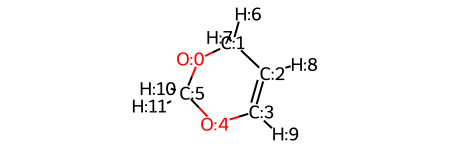

In [6]:
smiles_dummy = "O1CC=COC1"

mol_dummy = Chem.MolFromSmiles(smiles_dummy)
mol_dummy = Chem.AddHs(mol_dummy)
EmbedMolecule(mol_dummy, randomSeed=SEED)
for atom in mol_dummy.GetAtoms():
    atom.SetProp("atomLabel", f"{atom.GetSymbol()}:{atom.GetIdx()}")

mol_dummy

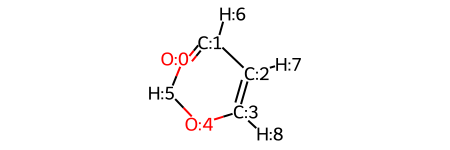

In [7]:
mol_mda_ts_cand = Chem.RWMol(mol_dummy)
mol_mda_ts_cand.RemoveAtom(11)
mol_mda_ts_cand.RemoveAtom(10)
mol_mda_ts_cand.RemoveAtom(7)
mol_mda_ts_cand.GetBondBetweenAtoms(0, 1).SetBondType(Chem.BondType.DOUBLE)
mol_mda_ts_cand.ReplaceAtom(5, Chem.Atom(1))
mol_mda_ts_cand = mol_mda_ts_cand.GetMol()

for atom in mol_mda_ts_cand.GetAtoms():
    atom.SetProp("atomLabel", f"{atom.GetSymbol()}:{atom.GetIdx()}")

mol_mda_ts_cand

In [8]:
ts_cand = read(StringIO(Chem.MolToXYZBlock(mol_mda_ts_cand)), format="xyz")
view(ts_cand, viewer="x3d")

In [9]:
ts_structure = ts_cand.copy()
ts_structure.calc = copy(calc)
ts_structure.info["charge"] = 0
ts_structure.info["spin"] = 1
opt_ts = Sella(
    ts_structure,
    trajectory=str(DIRPATH_TRAJ / "ts.traj"),
    logfile=str(DIRPATH_LOG / "ts.log"),
    order=1,  # ← index-1 saddle を探す
    eta=1e-4,  # 初期ステップサイズ。大きくすると高速に移動、小さくすると安定だが遅い
    gamma=0.01,  # 反復パラメータ（Sella 固有）。勾配の反映具合を調整
    internal=False,  # 内部座標系で最適化するか。False で Cartesian 最適化
    diag_every_n=1,
)
converged_ts = opt_ts.run(fmax=0.01)
logger.info(f"Converge ts structure: {converged_ts}")

view(ts_structure, viewer="x3d")

2025-08-21 16:48:42,237 [INFO] Converge ts structure: True


In [10]:
#  振動数計算
dirpath_vib_cache = DIRPATH_TRAJ / "cache"

# 遷移状態の構造を読み込み
# ts_structure = read("ts.traj", index=-1)  # 最後の構造を取得
ts_structure.calc = copy(calc)
ts_structure.info["charge"] = 0
ts_structure.info["spin"] = 1

# 振動数計算の設定
vib = Vibrations(
    ts_structure, delta=0.01, name=str(dirpath_vib_cache), nfree=2
)  # delta: 有限差分のステップサイズ（Å）

vib.clean()
# 振動数計算を実行
vib.run()

frequencies = vib.get_frequencies()
flag_imag_freq = ~np.isclose(frequencies.imag, 0.0)
n_imag_freqs = np.sum(flag_imag_freq).item()
# 結果の表示
logger.info("=== 振動数計算結果 ===")
logger.info(f"虚振動の数: {n_imag_freqs} / {flag_imag_freq.shape[0]}")

# 虚振動数の詳細表示
str_imag_freqs = "虚振動数 (cm^-1):"
if n_imag_freqs:
    for idx, freq in enumerate(frequencies):
        if flag_imag_freq[idx]:
            str_imag_freqs += f"\n  {idx}: {freq:8.2f}"
            # 虚振動のモードを可視化
            vib.write_mode(idx)
            (
                dirpath_vib_cache.parent
                / f"{dirpath_vib_cache.name}.{idx}.traj"
            ).rename(dirpath_vib_cache.parent / f"{jobname}.{idx}.traj")

    logger.info(str_imag_freqs)

buffer_io = StringIO()
vib.summary(log=buffer_io)
logger.info(f"\n{buffer_io.getvalue()}")

2025-08-21 16:48:47,385 [INFO] === 振動数計算結果 ===
2025-08-21 16:48:47,386 [INFO] 虚振動の数: 4 / 27
2025-08-21 16:48:47,406 [INFO] 虚振動数 (cm^-1):
  0: 0.00+1295.09j
  1: 0.00+5.35j
  2: 0.00+4.00j
  3: 0.00+0.18j
2025-08-21 16:48:47,408 [INFO] 
---------------------
  #    meV     cm^-1
---------------------
  0  160.6i   1295.1i
  1    0.7i      5.4i
  2    0.5i      4.0i
  3    0.0i      0.2i
  4    0.0       0.3
  5    0.0       0.4
  6    1.2       9.8
  7   45.2     364.3
  8   47.7     384.9
  9   70.9     571.7
 10   77.6     625.8
 11   95.7     771.8
 12  118.0     951.7
 13  126.2    1017.7
 14  131.8    1063.4
 15  133.2    1074.4
 16  137.4    1107.8
 17  159.2    1283.7
 18  165.5    1334.7
 19  171.4    1382.8
 20  187.9    1515.2
 21  202.8    1635.7
 22  206.6    1666.2
 23  232.2    1873.2
 24  385.5    3109.2
 25  385.8    3112.1
 26  404.5    3262.6
---------------------
Zero-point energy: 1.743 eV



In [11]:
ind = 0
traj_vib = Trajectory(DIRPATH_TRAJ / f"{jobname}.{ind}.traj")
# write(f"vib.{ind}.gif", traj_vib, format="gif")
view(traj_vib, viewer="ngl")

In [12]:
ts_irc_forward = ts_structure.copy()
ts_irc_forward.calc = copy(calc)
ts_irc_forward.info["charge"] = 0
ts_irc_forward.info["spin"] = 1

opt_irc_forward = IRC(
    ts_irc_forward,
    logfile=str(DIRPATH_LOG / "irc_forward.log"),
    trajectory=str(DIRPATH_TRAJ / "irc_forward.traj"),
    eta=1e-4,  # 初期ステップサイズ。大きくすると高速に移動、小さくすると安定だが遅い
    gamma=0.01,  # 反復パラメータ（Sella 固有）。勾配の反映具合を調整
)
converged_irc_forward = opt_irc_forward.run(
    fmax=0.01,
    steps=10000,
    direction="forward",
)
logger.info(f"Converged IRC (foward): {converged_irc_forward}")

traj_forward = Trajectory(str(DIRPATH_TRAJ / "irc_forward.traj"))
view(traj_forward, viewer="ngl")

2025-08-21 16:48:47,719 [WARNING] /home/yu9824/opt/miniforge3/envs/fairchem312/lib/python3.12/site-packages/sella/peswrapper.py:325: RuntimeWarning: invalid value encountered in scalar divide
  ratio = df_actual / df_pred

2025-08-21 16:48:51,701 [INFO] Converged IRC (foward): True


In [13]:
ts_irc_reverse = ts_structure.copy()
ts_irc_reverse.calc = copy(calc)
ts_irc_reverse.info["charge"] = 0
ts_irc_reverse.info["spin"] = 1

opt_irc_reverse = IRC(
    ts_irc_reverse,
    logfile=str(DIRPATH_LOG / "irc_reverse.log"),
    trajectory=str(DIRPATH_TRAJ / "irc_reverse.traj"),
    eta=1e-4,  # 初期ステップサイズ。大きくすると高速に移動、小さくすると安定だが遅い
    gamma=0.01,  # 反復パラメータ（Sella 固有）。勾配の反映具合を調整
)
converged_irc_reverse = opt_irc_reverse.run(
    fmax=0.01,
    steps=10000,
    direction="reverse",
)
logger.info(f"Converged IRC (reverse): {converged_irc_reverse}")

traj_reverse = Trajectory(str(DIRPATH_TRAJ / "irc_reverse.traj"))
view(traj_reverse, viewer="ngl")

2025-08-21 16:48:56,355 [INFO] Converged IRC (reverse): True


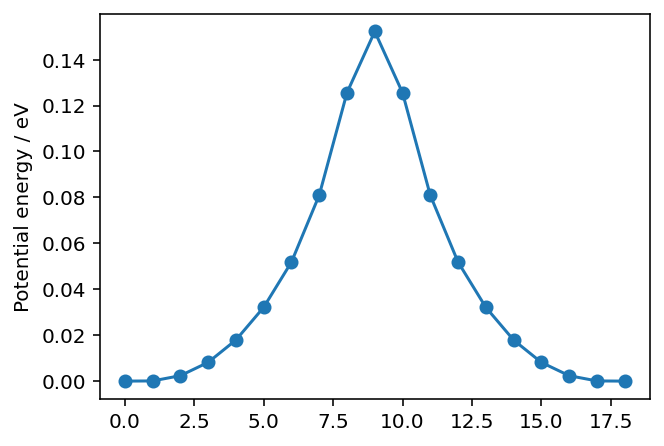

In [14]:
tup_atoms_irc = tuple(traj_reverse)[::-1] + tuple(traj_forward[1:])
energies = np.array(
    [_atoms.get_potential_energy() for _atoms in tup_atoms_irc]
)
energies -= energies.min()

fig, ax = plt.subplots(dpi=144, figsize=(4.8, 3.2))
ax.plot(energies, marker="o")
ax.ticklabel_format(style="plain", useOffset=False)
ax.set_ylabel("Potential energy / eV")
fig.tight_layout()

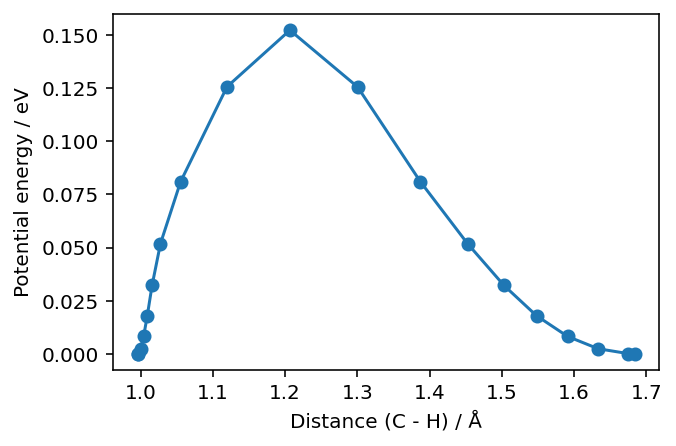

In [15]:
distance_o_and_h = np.asarray(
    [
        np.sqrt(
            (
                np.diff(tup_atoms_irc[frame].get_positions()[[0, 5]], axis=0)
                ** 2
            ).sum()
        )
        for frame in range(len(tup_atoms_irc))
    ]
)
fig, ax = plt.subplots(dpi=144, figsize=(4.8, 3.2))
ax.plot(distance_o_and_h, energies, marker="o")
ax.ticklabel_format(style="plain", useOffset=False)
ax.set_xlabel("Distance (C - H) / Å")
ax.set_ylabel("Potential energy / eV")
fig.tight_layout()

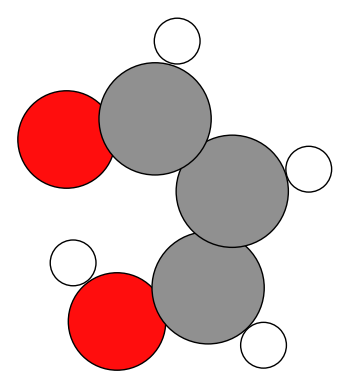

In [16]:
write(str(DIRPATH_OUT / f"{jobname}.gif"), tup_atoms_irc, format="gif")